# LME銅 Cash/3Mスプレッドボラティリティ・リスク分析

## 分析目的
このノートブックは、Cash/3Mスプレッドのボラティリティパターンとリスク特性を調査し、以下を理解します：
1. **スプレッドボラティリティ**: スプレッド固有のリスク特性
2. **リスク指標**: VaR、期待ショートフォール、ドローダウン分析
3. **ボラティリティ動力学**: GARCH効果とボラティリティ持続性
4. **市場体制分析**: 低/高ボラティリティ期間の特徴
5. **極値事象**: テールリスクとストレステスト

## 主要概念と解釈
- **スプレッドボラティリティ**: 絶対価格ボラティリティとは異なる特性
  - 低: <5 USD/ton（安定期間）
  - 中程度: 5-15 USD/ton（通常市場状況）
  - 高: >15 USD/ton（ストレス状況）

- **スプレッド固有リスク**:
  - 市場中立的な性質
  - 平均回帰傾向
  - 相対的に低い市場露出

- **バリューアットリスク（VaR）**: スプレッド取引でのポジション損失
- **体制変化**: バックワーデーション/コンタンゴでの異なるリスク
- **裁定機会**: 異常なボラティリティスパイク時の取引機会

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats
from scipy.stats import jarque_bera, normaltest, skew, kurtosis

# Try to import optional packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

try:
    import arch
    from arch import arch_model
    import statsmodels.api as sm
    ARCH_AVAILABLE = True
except ImportError:
    print("ARCH package not available. GARCH modeling will use simplified methods.")
    ARCH_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [12, 8]

ARCH package not available. GARCH modeling will use simplified methods.


## データ読み込みとスプレッド準備

In [2]:
def load_spread_data_comprehensive():
    """Cash/3Mスプレッドと関連データを包括的に読み込み"""
    try:
        engine = create_engine(connection_string)
        
        # Cash/3Mスプレッドデータ
        spread_query = """
        SELECT 
            trade_date,
            ric,
            last_price as spread_price,
            volume as spread_volume
        FROM lme_copper_prices
        WHERE price_type = 'CASH_3M_SPREAD' 
        AND last_price IS NOT NULL
        ORDER BY trade_date
        """
        
        # CashとCMCU3（3M）価格（リスク要因分析用）
        components_query = """
        SELECT 
            trade_date,
            ric,
            last_price,
            volume,
            price_type
        FROM lme_copper_prices
        WHERE price_type IN ('CASH', '3M') 
        AND last_price IS NOT NULL
        ORDER BY trade_date, price_type
        """
        
        # データ読み込み
        spread_df = pd.read_sql_query(spread_query, engine)
        components_df = pd.read_sql_query(components_query, engine)
        
        engine.dispose()
        
        # データ前処理
        spread_df['trade_date'] = pd.to_datetime(spread_df['trade_date'])
        components_df['trade_date'] = pd.to_datetime(components_df['trade_date'])
        
        # スプレッド時系列を作成
        spread_ts = spread_df.set_index('trade_date')['spread_price'].sort_index()
        volume_ts = spread_df.set_index('trade_date')['spread_volume'].sort_index()
        
        # コンポーネント価格マトリックス
        component_matrix = components_df.pivot(index='trade_date', columns='price_type', values='last_price')
        
        # 前方補完
        spread_ts = spread_ts.ffill()
        volume_ts = volume_ts.ffill()
        component_matrix = component_matrix.ffill()
        
        # スプレッド変化計算
        spread_changes = spread_ts.diff().dropna()
        spread_returns = spread_ts.pct_change().dropna() * 100
        
        # 追加メトリクス
        spread_direction = np.where(spread_ts > 0, 'Backwardation', 'Contango')
        spread_direction_series = pd.Series(spread_direction, index=spread_ts.index)
        
        print(f"スプレッドデータ読み込み完了:")
        print(f"期間: {spread_ts.index.min()} ～ {spread_ts.index.max()}")
        print(f"データポイント数: {len(spread_ts)}")
        print(f"スプレッド範囲: {spread_ts.min():.2f} ～ {spread_ts.max():.2f} USD/ton")
        
        return spread_ts, spread_changes, spread_returns, volume_ts, component_matrix, spread_direction_series
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None, None, None, None, None, None

# データ読み込み
spread_prices, spread_changes, spread_returns, spread_volume, components, spread_direction = load_spread_data_comprehensive()

スプレッドデータ読み込み完了:
期間: 2022-07-06 00:00:00 ～ 2025-07-04 00:00:00
データポイント数: 758
スプレッド範囲: -161.41 ～ 319.83 USD/ton


## 1. スプレッドボラティリティ分析

### 解釈ガイド:
- **スプレッドボラティリティ**: 絶対価格変動とは異なる特性
- **低ボラティリティ**: 安定した市場構造、限定的裁定機会
- **高ボラティリティ**: 市場ストレス、在庫変動、重要なニュース
- **ボラティリティ体制**: 構造的変化の期間

In [3]:
if spread_prices is not None:
    # スプレッドボラティリティ指標計算
    
    # 1. 絶対変化のボラティリティ
    daily_vol_abs = abs(spread_changes).rolling(30).mean()
    
    # 2. リターンベースボラティリティ
    daily_vol_pct = spread_returns.rolling(30).std()
    
    # 3. レンジベースボラティリティ推定
    rolling_std = spread_prices.rolling(30).std()
    
    # 4. 実現ボラティリティ（高頻度）
    realized_vol = abs(spread_changes).rolling(30).std()
    
    # 統計計算
    vol_stats = {
        'Mean_Abs_Change': abs(spread_changes).mean(),
        'Std_Abs_Change': abs(spread_changes).std(),
        'Mean_Daily_Vol': daily_vol_abs.mean(),
        'Max_Daily_Vol': daily_vol_abs.max(),
        'Min_Daily_Vol': daily_vol_abs.min(),
        'Vol_of_Vol': daily_vol_abs.std(),
        'Mean_Return_Vol': daily_vol_pct.mean(),
        'Mean_Realized_Vol': realized_vol.mean()
    }
    
    print("Cash/3Mスプレッドボラティリティ分析:")
    print("="*50)
    
    for metric, value in vol_stats.items():
        if not np.isnan(value):
            print(f"{metric}: {value:.3f}")
    
    # ボラティリティ体制分析
    vol_quantiles = daily_vol_abs.quantile([0.25, 0.5, 0.75, 0.9]).round(3)
    
    print(f"\nボラティリティ体制分析:")
    print(f"低ボラティリティ（25%以下): {vol_quantiles[0.25]:.3f} USD/ton以下")
    print(f"中程度ボラティリティ（25-75%): {vol_quantiles[0.25]:.3f} - {vol_quantiles[0.75]:.3f} USD/ton")
    print(f"高ボラティリティ（75%以上): {vol_quantiles[0.75]:.3f} USD/ton以上")
    print(f"極度ボラティリティ（90%以上): {vol_quantiles[0.9]:.3f} USD/ton以上")
    
    # 市場構造別ボラティリティ
    if spread_direction is not None:
        backwardation_vol = daily_vol_abs[spread_direction == 'Backwardation'].mean()
        contango_vol = daily_vol_abs[spread_direction == 'Contango'].mean()
        
        print(f"\n市場構造別ボラティリティ:")
        print(f"バックワーデーション期間: {backwardation_vol:.3f} USD/ton")
        print(f"コンタンゴ期間: {contango_vol:.3f} USD/ton")
        print(f"ボラティリティ比率: {backwardation_vol/contango_vol:.2f}倍")
else:
    print("データが読み込まれていません")

Cash/3Mスプレッドボラティリティ分析:
Mean_Abs_Change: 8.827
Std_Abs_Change: 14.228
Mean_Daily_Vol: 8.110
Max_Daily_Vol: 36.533
Min_Daily_Vol: 3.626
Vol_of_Vol: 4.998
Mean_Return_Vol: 85.223
Mean_Realized_Vol: 7.380

ボラティリティ体制分析:
低ボラティリティ（25%以下): 4.766 USD/ton以下
中程度ボラティリティ（25-75%): 4.766 - 10.563 USD/ton
高ボラティリティ（75%以上): 10.563 USD/ton以上
極度ボラティリティ（90%以上): 15.488 USD/ton以上

市場構造別ボラティリティ:
バックワーデーション期間: 14.111 USD/ton
コンタンゴ期間: 6.706 USD/ton
ボラティリティ比率: 2.10倍


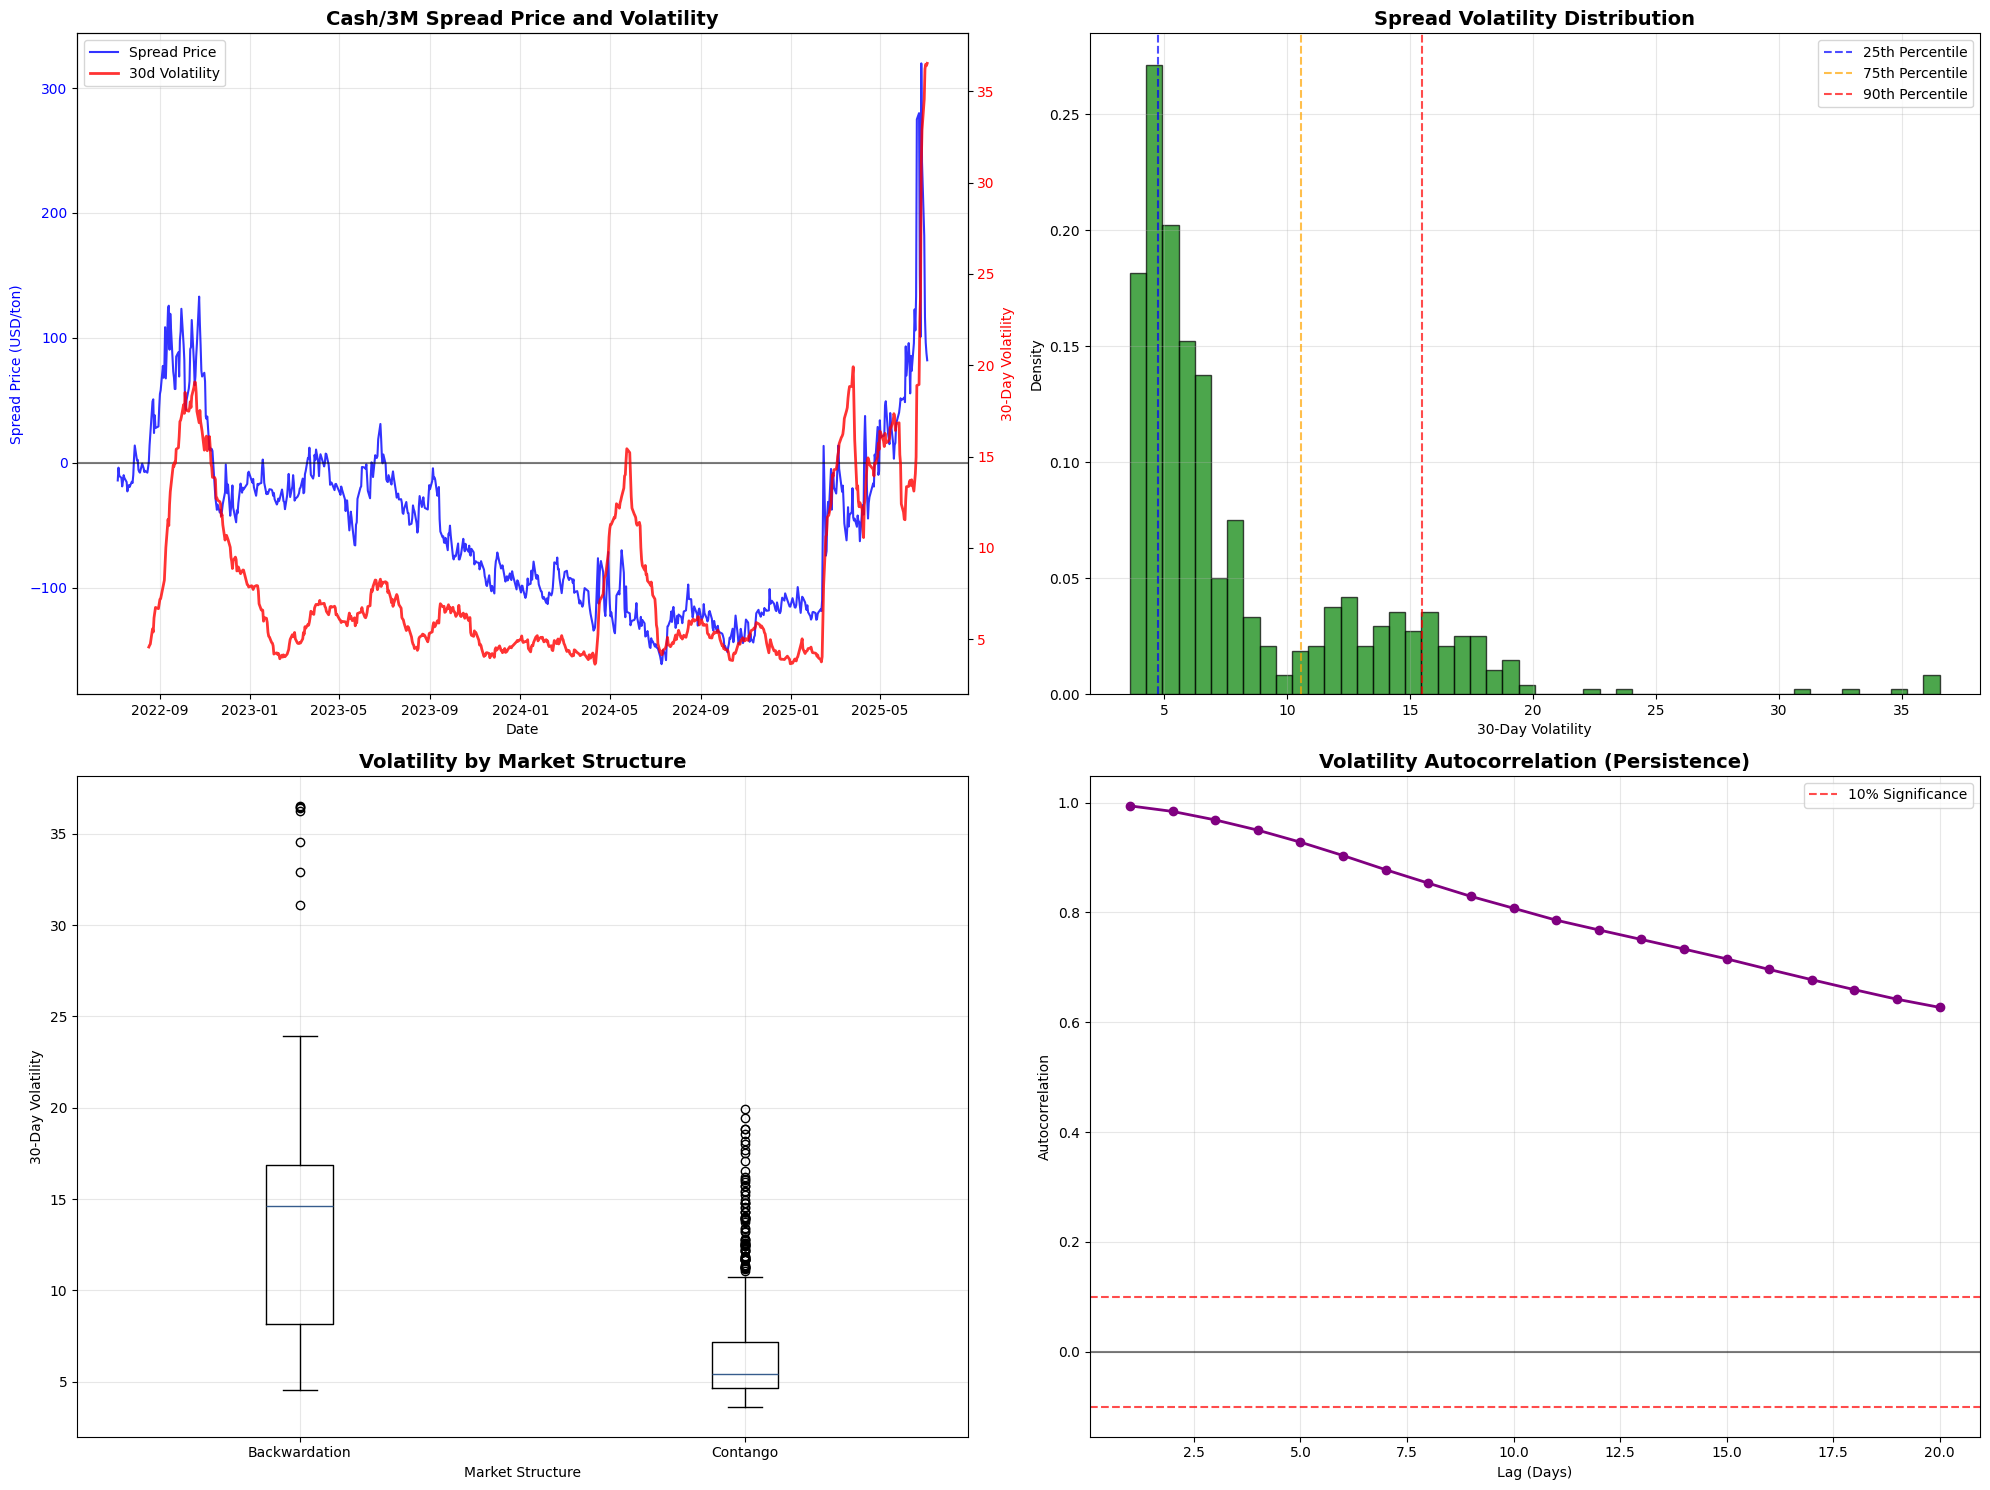

In [4]:
if spread_prices is not None:
    # スプレッドボラティリティ可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. スプレッド価格とボラティリティ
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(spread_prices.index, spread_prices, 
                     color='blue', linewidth=1.5, alpha=0.8, label='Spread Price')
    line2 = ax1_twin.plot(daily_vol_abs.index, daily_vol_abs, 
                          color='red', linewidth=2, alpha=0.8, label='30d Volatility')
    
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_title('Cash/3M Spread Price and Volatility', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Spread Price (USD/ton)', color='blue')
    ax1_twin.set_ylabel('30-Day Volatility', color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1_twin.tick_params(axis='y', labelcolor='red')
    
    # 凡例結合
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. ボラティリティ分布
    ax2.hist(daily_vol_abs.dropna(), bins=50, alpha=0.7, color='green', 
             edgecolor='black', density=True)
    
    # 体制境界をマーク
    ax2.axvline(x=vol_quantiles[0.25], color='blue', linestyle='--', alpha=0.7, label='25th Percentile')
    ax2.axvline(x=vol_quantiles[0.75], color='orange', linestyle='--', alpha=0.7, label='75th Percentile')
    ax2.axvline(x=vol_quantiles[0.9], color='red', linestyle='--', alpha=0.7, label='90th Percentile')
    
    ax2.set_title('Spread Volatility Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('30-Day Volatility')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 市場構造別ボラティリティ
    if spread_direction is not None:
        back_vol = daily_vol_abs[spread_direction == 'Backwardation'].dropna()
        cont_vol = daily_vol_abs[spread_direction == 'Contango'].dropna()
        
        ax3.boxplot([back_vol, cont_vol], labels=['Backwardation', 'Contango'])
        ax3.set_title('Volatility by Market Structure', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Market Structure')
        ax3.set_ylabel('30-Day Volatility')
        ax3.grid(True, alpha=0.3)
    
    # 4. ボラティリティ持続性分析
    # ボラティリティの自己相関
    vol_autocorr = [daily_vol_abs.autocorr(lag=i) for i in range(1, 21)]
    lags = list(range(1, 21))
    
    ax4.plot(lags, vol_autocorr, marker='o', linewidth=2, markersize=6, color='purple')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='10% Significance')
    ax4.axhline(y=-0.1, color='red', linestyle='--', alpha=0.7)
    
    ax4.set_title('Volatility Autocorrelation (Persistence)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Lag (Days)')
    ax4.set_ylabel('Autocorrelation')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_volatility_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 2. スプレッドリスク指標とVaR分析

### 解釈ガイド:
- **スプレッドVaR**: ポジション損失の潜在的リスク
- **期待ショートフォール**: VaR超過時の平均損失
- **最大ドローダウン**: スプレッド戦略の最大損失
- **リスク調整指標**: シャープレシオ、カルマーレシオ

In [5]:
if spread_changes is not None and spread_returns is not None:
    # スプレッドリスク指標計算
    
    # 基本統計
    mean_change = spread_changes.mean()
    std_change = spread_changes.std()
    
    # VaR計算（絶対値変化ベース）
    var_95_abs = np.percentile(spread_changes, 5)
    var_99_abs = np.percentile(spread_changes, 1)
    var_95_up = np.percentile(spread_changes, 95)
    var_99_up = np.percentile(spread_changes, 99)
    
    # VaR計算（リターンベース）
    var_95_ret = np.percentile(spread_returns, 5)
    var_99_ret = np.percentile(spread_returns, 1)
    
    # 期待ショートフォール
    es_95_abs = spread_changes[spread_changes <= var_95_abs].mean()
    es_99_abs = spread_changes[spread_changes <= var_99_abs].mean()
    es_95_up = spread_changes[spread_changes >= var_95_up].mean()
    es_99_up = spread_changes[spread_changes >= var_99_up].mean()
    
    # 最大ドローダウン（累積スプレッド変化）
    cumulative_pnl = spread_changes.cumsum()
    rolling_max = cumulative_pnl.expanding().max()
    drawdown = cumulative_pnl - rolling_max
    max_drawdown = drawdown.min()
    
    # 最大上昇
    rolling_min = cumulative_pnl.expanding().min()
    upside = cumulative_pnl - rolling_min
    max_upside = upside.max()
    
    # 下方偏差
    downside_changes = spread_changes[spread_changes < 0]
    downside_deviation = downside_changes.std() if len(downside_changes) > 0 else 0
    
    # 上方偏差
    upside_changes = spread_changes[spread_changes > 0]
    upside_deviation = upside_changes.std() if len(upside_changes) > 0 else 0
    
    # リスク調整指標
    sharpe_ratio = mean_change / std_change if std_change > 0 else 0
    calmar_ratio = mean_change / abs(max_drawdown) if max_drawdown < 0 else 0
    gain_pain_ratio = max_upside / abs(max_drawdown) if max_drawdown < 0 else float('inf')
    
    # 分布特性
    skewness = skew(spread_changes)
    kurt = kurtosis(spread_changes)
    
    print("Cash/3Mスプレッドリスク分析:")
    print("="*50)
    
    print(f"基本統計:")
    print(f"平均日次変化: {mean_change:.3f} USD/ton")
    print(f"標準偏差: {std_change:.3f} USD/ton")
    print(f"歪度: {skewness:.3f}")
    print(f"尖度: {kurt:.3f}")
    
    print(f"\nバリューアットリスク（下方）:")
    print(f"95% VaR: {var_95_abs:.3f} USD/ton")
    print(f"99% VaR: {var_99_abs:.3f} USD/ton")
    
    print(f"\nバリューアットリスク（上方）:")
    print(f"95% VaR: {var_95_up:.3f} USD/ton")
    print(f"99% VaR: {var_99_up:.3f} USD/ton")
    
    print(f"\n期待ショートフォール:")
    print(f"95% ES (下方): {es_95_abs:.3f} USD/ton")
    print(f"99% ES (下方): {es_99_abs:.3f} USD/ton")
    print(f"95% ES (上方): {es_95_up:.3f} USD/ton")
    print(f"99% ES (上方): {es_99_up:.3f} USD/ton")
    
    print(f"\nドローダウン分析:")
    print(f"最大ドローダウン: {max_drawdown:.3f} USD/ton")
    print(f"最大上昇: {max_upside:.3f} USD/ton")
    
    print(f"\nリスク調整指標:")
    print(f"シャープレシオ: {sharpe_ratio:.4f}")
    print(f"カルマーレシオ: {calmar_ratio:.4f}")
    print(f"利得・損失比率: {gain_pain_ratio:.2f}")
    
    print(f"\n偏差分析:")
    print(f"下方偏差: {downside_deviation:.3f} USD/ton")
    print(f"上方偏差: {upside_deviation:.3f} USD/ton")
    print(f"非対称比率: {upside_deviation/downside_deviation:.2f}" if downside_deviation > 0 else "N/A")
else:
    print("スプレッドデータが利用できません")

Cash/3Mスプレッドリスク分析:
基本統計:
平均日次変化: 0.127 USD/ton
標準偏差: 16.746 USD/ton
歪度: 2.829
尖度: 51.647

バリューアットリスク（下方）:
95% VaR: -17.150 USD/ton
99% VaR: -39.522 USD/ton

バリューアットリスク（上方）:
95% VaR: 18.818 USD/ton
99% VaR: 42.648 USD/ton

期待ショートフォール:
95% ES (下方): -36.082 USD/ton
99% ES (下方): -72.393 USD/ton
95% ES (上方): 39.397 USD/ton
99% ES (上方): 86.315 USD/ton

ドローダウン分析:
最大ドローダウン: -294.410 USD/ton
最大上昇: 481.240 USD/ton

リスク調整指標:
シャープレシオ: 0.0076
カルマーレシオ: 0.0004
利得・損失比率: 1.63

偏差分析:
下方偏差: 12.323 USD/ton
上方偏差: 15.986 USD/ton
非対称比率: 1.30


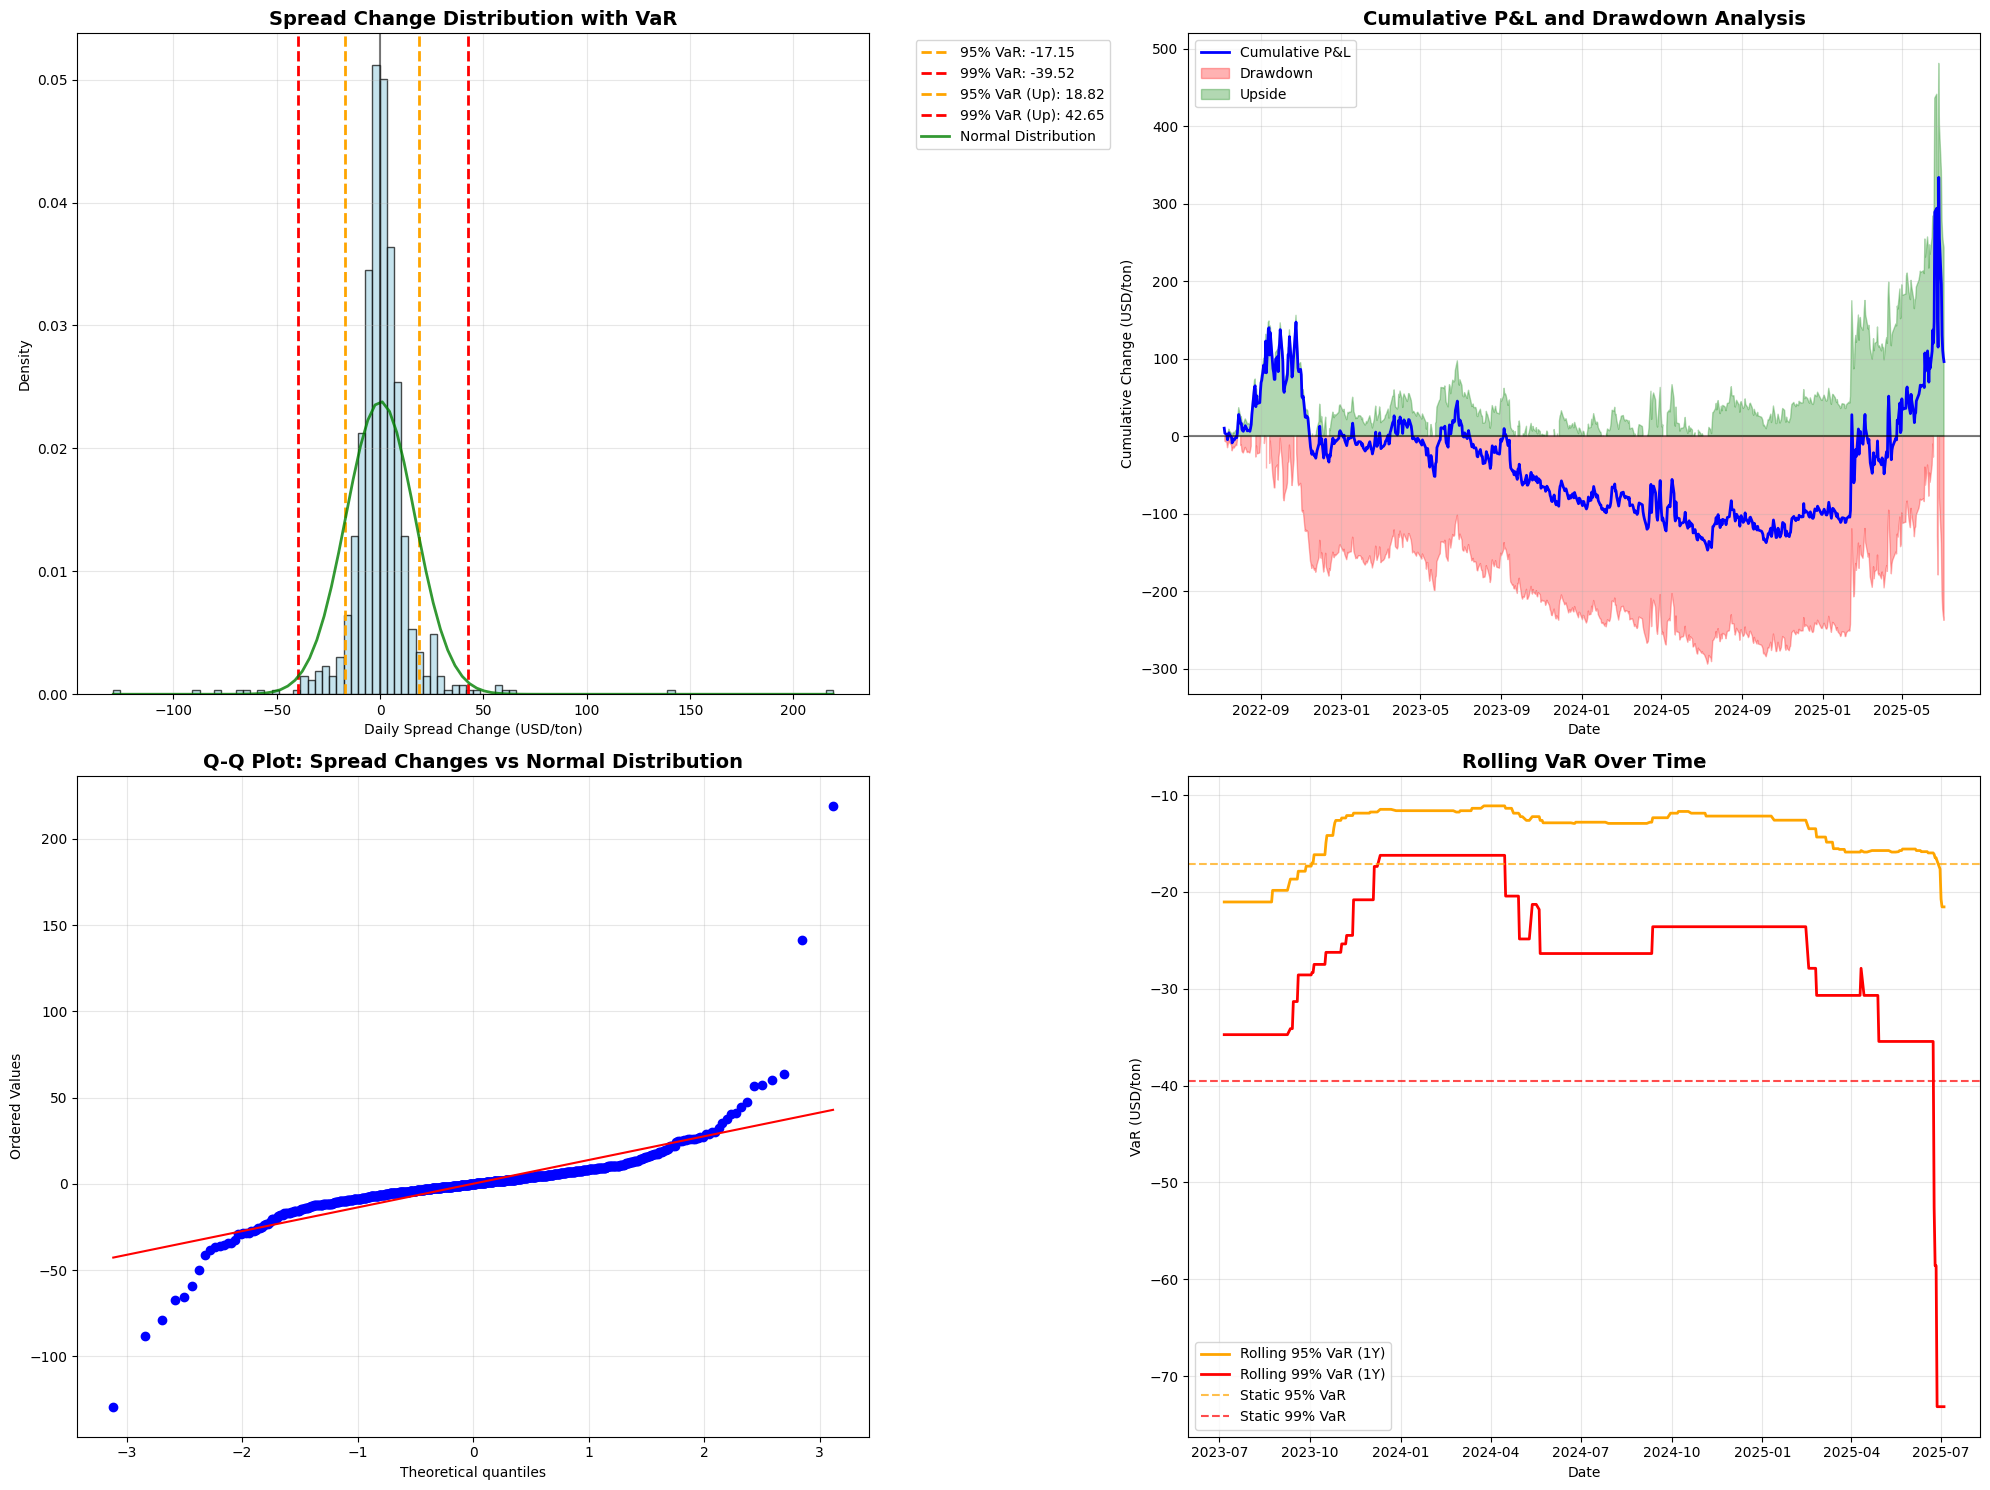

In [6]:
if spread_changes is not None:
    # リスク指標可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. VaRとスプレッド分布
    ax1.hist(spread_changes, bins=100, alpha=0.7, color='lightblue', 
             density=True, edgecolor='black')
    
    # VaR線を追加
    ax1.axvline(x=var_95_abs, color='orange', linestyle='--', linewidth=2, 
                label=f'95% VaR: {var_95_abs:.2f}')
    ax1.axvline(x=var_99_abs, color='red', linestyle='--', linewidth=2, 
                label=f'99% VaR: {var_99_abs:.2f}')
    ax1.axvline(x=var_95_up, color='orange', linestyle='--', linewidth=2, 
                label=f'95% VaR (Up): {var_95_up:.2f}')
    ax1.axvline(x=var_99_up, color='red', linestyle='--', linewidth=2, 
                label=f'99% VaR (Up): {var_99_up:.2f}')
    
    # 正規分布オーバーレイ
    x = np.linspace(spread_changes.min(), spread_changes.max(), 100)
    normal_dist = stats.norm.pdf(x, mean_change, std_change)
    ax1.plot(x, normal_dist, 'g-', linewidth=2, alpha=0.8, label='Normal Distribution')
    
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax1.set_title('Spread Change Distribution with VaR', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Daily Spread Change (USD/ton)')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. 累積P&Lとドローダウン
    ax2.plot(cumulative_pnl.index, cumulative_pnl, linewidth=2, color='blue', 
             label='Cumulative P&L')
    ax2.fill_between(drawdown.index, 0, drawdown, 
                     where=(drawdown < 0), alpha=0.3, color='red', 
                     label='Drawdown')
    ax2.fill_between(upside.index, 0, upside, 
                     where=(upside > 0), alpha=0.3, color='green', 
                     label='Upside')
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_title('Cumulative P&L and Drawdown Analysis', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Change (USD/ton)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Qプロット（正規性検定）
    stats.probplot(spread_changes, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot: Spread Changes vs Normal Distribution', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # 4. ローリングボラティリティとVaR
    rolling_var_95 = spread_changes.rolling(252).quantile(0.05)
    rolling_var_99 = spread_changes.rolling(252).quantile(0.01)
    
    ax4.plot(rolling_var_95.index, rolling_var_95, linewidth=2, color='orange', 
             label='Rolling 95% VaR (1Y)')
    ax4.plot(rolling_var_99.index, rolling_var_99, linewidth=2, color='red', 
             label='Rolling 99% VaR (1Y)')
    
    # 固定VaRライン
    ax4.axhline(y=var_95_abs, color='orange', linestyle='--', alpha=0.7, 
                label='Static 95% VaR')
    ax4.axhline(y=var_99_abs, color='red', linestyle='--', alpha=0.7, 
                label='Static 99% VaR')
    
    ax4.set_title('Rolling VaR Over Time', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('VaR (USD/ton)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_risk_var_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 3. スプレッドボラティリティモデリング（GARCH）

### 解釈ガイド:
- **GARCH効果**: スプレッドボラティリティのクラスタリング
- **条件付きボラティリティ**: 時変リスク推定
- **ボラティリティ予測**: 将来のリスク水準予測
- **体制変化**: ボラティリティ構造の変化

In [7]:
def fit_spread_garch_model(spread_changes_series):
    """スプレッド用のGARCHモデルフィット"""
    try:
        # データ準備
        clean_changes = spread_changes_series.dropna()
        
        if len(clean_changes) < 100:
            return None
        
        if ARCH_AVAILABLE:
            # GARCH(1,1)モデルフィット
            model = arch_model(clean_changes, vol='GARCH', p=1, q=1, rescale=False)
            fitted_model = model.fit(disp='off')
            
            # パラメータ抽出
            params = fitted_model.params
            alpha = params['alpha[1]'] if 'alpha[1]' in params else 0
            beta = params['beta[1]'] if 'beta[1]' in params else 0
            omega = params['omega'] if 'omega' in params else 0
            
            # 持続性
            persistence = alpha + beta
            
            # 条件付きボラティリティ
            conditional_vol = fitted_model.conditional_volatility
            
            # ボラティリティ予測（5日先）
            forecast = fitted_model.forecast(horizon=5, reindex=False)
            
            return {
                'model': fitted_model,
                'alpha': alpha,
                'beta': beta,
                'omega': omega,
                'persistence': persistence,
                'conditional_vol': conditional_vol,
                'forecast': forecast,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic
            }
        else:
            # 簡単なボラティリティ分析
            squared_changes = clean_changes ** 2
            
            # ボラティリティクラスタリング（自己相関）
            vol_clustering = squared_changes.autocorr(lag=1)
            
            # ローリングボラティリティ
            rolling_vol = abs(clean_changes).rolling(30).mean()
            
            return {
                'vol_clustering': vol_clustering,
                'rolling_vol': rolling_vol,
                'mean_vol': rolling_vol.mean(),
                'vol_persistence': vol_clustering
            }
    
    except Exception as e:
        print(f"GARCHモデルフィットが失敗: {e}")
        return None

if spread_changes is not None:
    # スプレッドGARCHモデル
    garch_result = fit_spread_garch_model(spread_changes)
    
    if garch_result:
        print("Cash/3Mスプレッド GARCH分析:")
        print("="*50)
        
        if ARCH_AVAILABLE and 'alpha' in garch_result:
            print(f"GARCH(1,1)パラメータ:")
            print(f"ω (omega): {garch_result['omega']:.6f}")
            print(f"α (alpha): {garch_result['alpha']:.4f}")
            print(f"β (beta): {garch_result['beta']:.4f}")
            print(f"持続性 (α+β): {garch_result['persistence']:.4f}")
            
            print(f"\nモデル適合度:")
            print(f"AIC: {garch_result['aic']:.2f}")
            print(f"BIC: {garch_result['bic']:.2f}")
            
            # 解釈
            if garch_result['persistence'] > 0.9:
                print(f"\n解釈: 高いボラティリティ持続性 - ショックが長期間持続")
            elif garch_result['persistence'] > 0.7:
                print(f"\n解釈: 中程度のボラティリティ持続性")
            else:
                print(f"\n解釈: 低いボラティリティ持続性 - ショックは素早く減衰")
            
            if garch_result['alpha'] > garch_result['beta']:
                print(f"ARCH効果優位: 最近のショックの影響が大きい")
            else:
                print(f"GARCH効果優位: 長期ボラティリティの影響が大きい")
        
        else:
            print(f"簡易ボラティリティ分析:")
            print(f"ボラティリティクラスタリング: {garch_result['vol_clustering']:.4f}")
            print(f"平均ローリングボラティリティ: {garch_result['mean_vol']:.3f} USD/ton")
    else:
        print("GARCHモデル分析ができませんでした")
else:
    print("スプレッドデータが利用できません")

Cash/3Mスプレッド GARCH分析:
簡易ボラティリティ分析:
ボラティリティクラスタリング: 0.1685
平均ローリングボラティリティ: 8.110 USD/ton


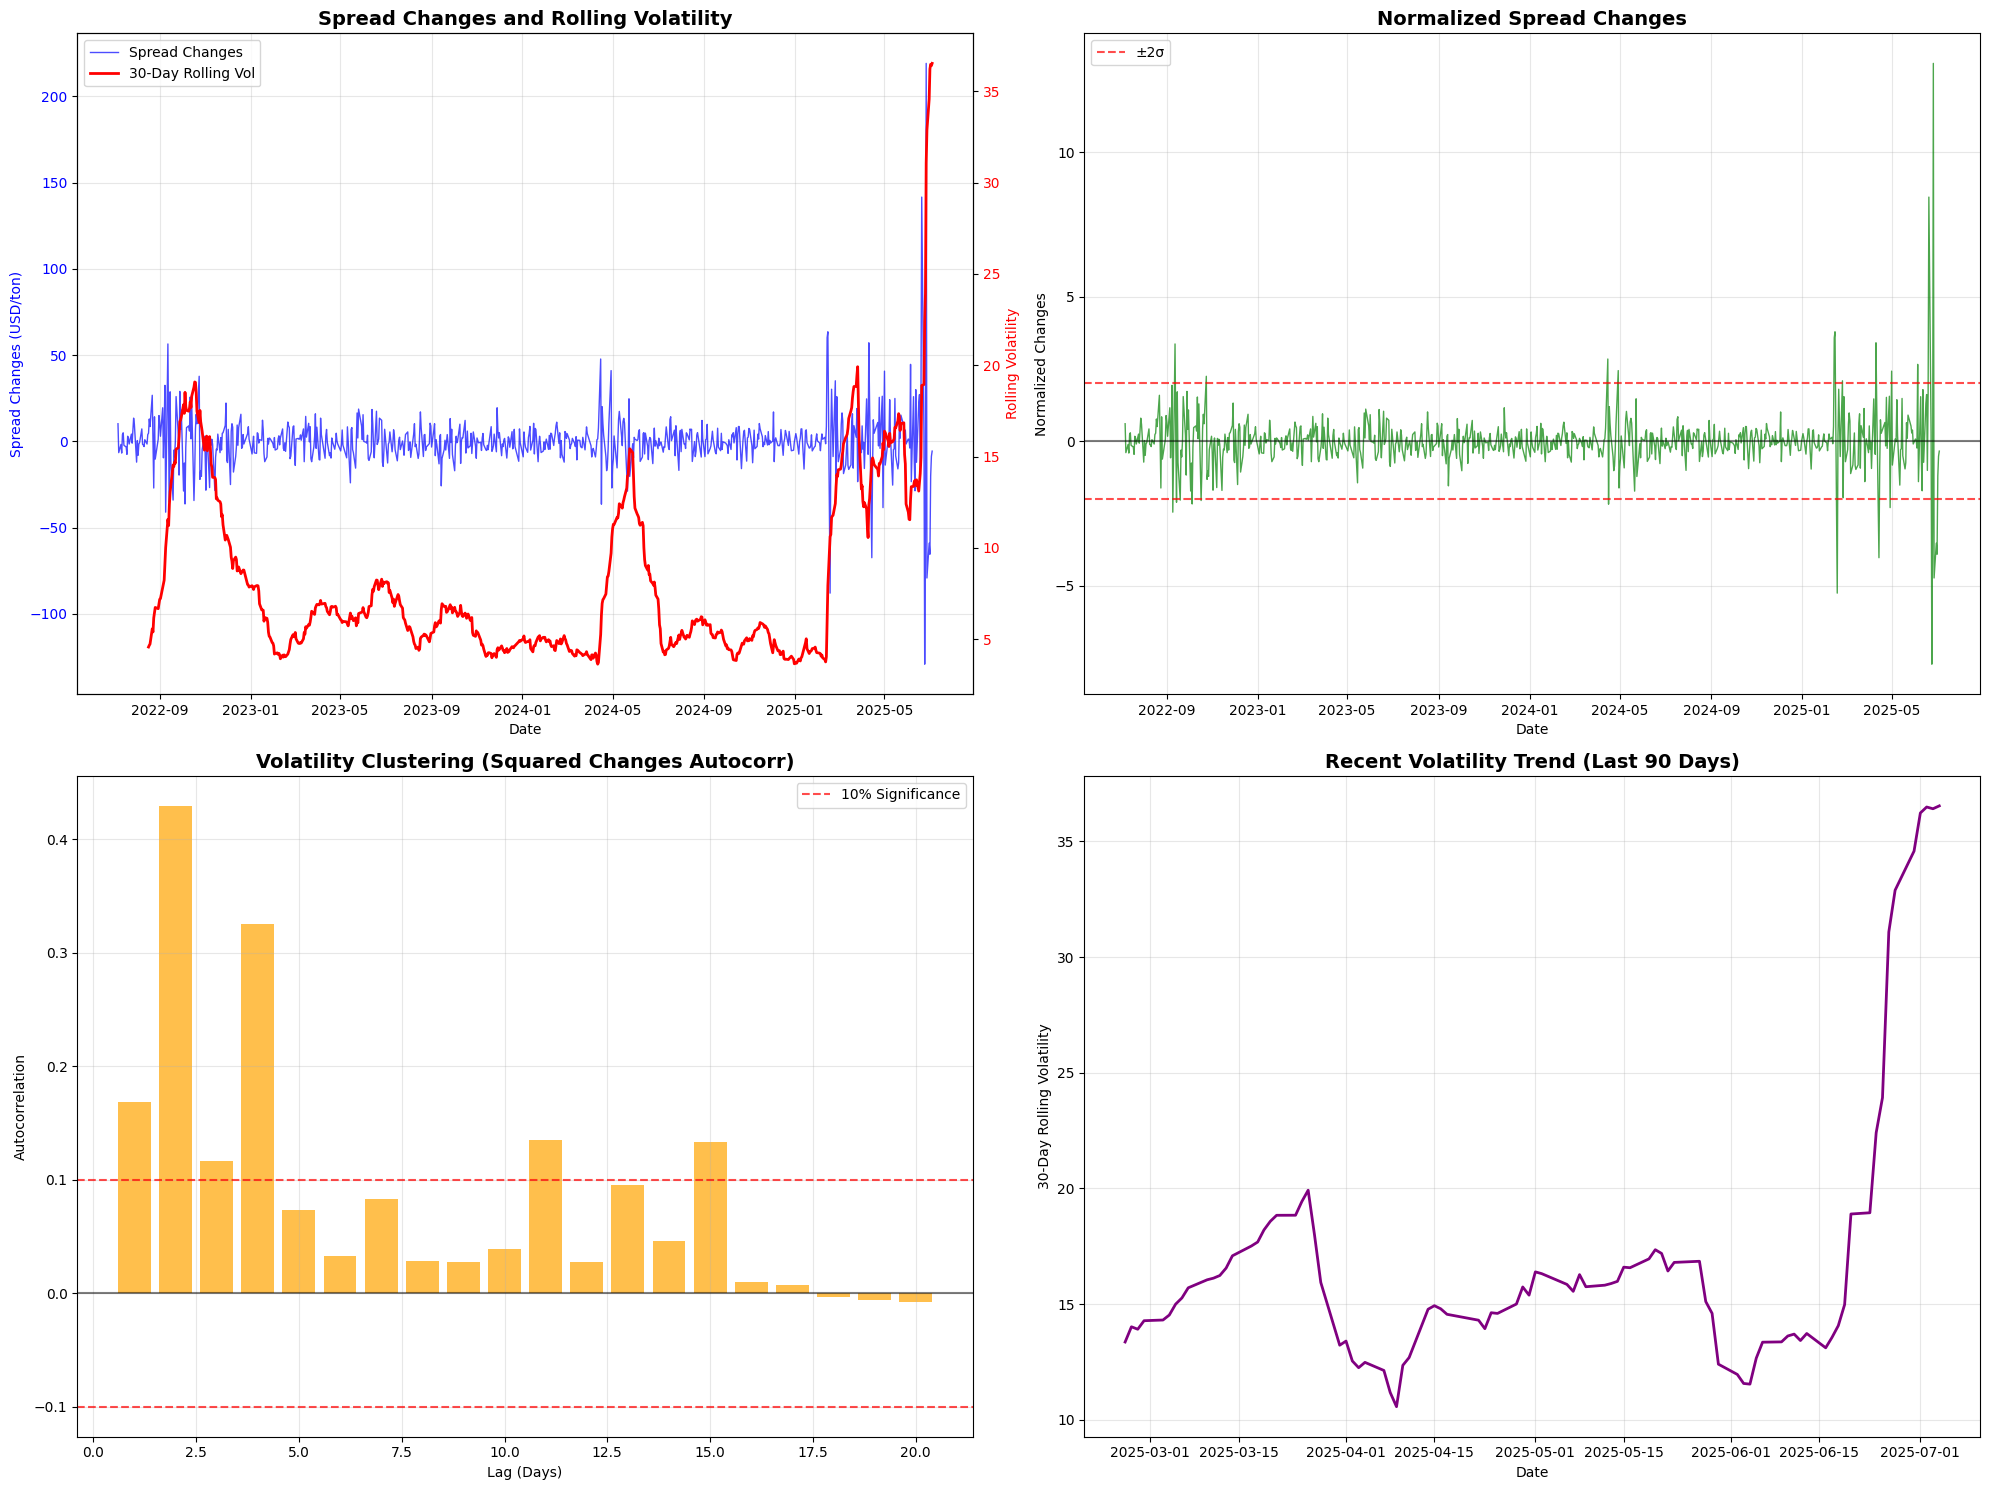

In [8]:
if spread_changes is not None and garch_result:
    # GARCHモデル可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. スプレッド変化と条件付きボラティリティ
    if ARCH_AVAILABLE and 'conditional_vol' in garch_result:
        conditional_vol = garch_result['conditional_vol']
        
        ax1.plot(spread_changes.index, spread_changes, alpha=0.7, linewidth=1, 
                 color='blue', label='Spread Changes')
        ax1_twin = ax1.twinx()
        ax1_twin.plot(conditional_vol.index, conditional_vol, linewidth=2, 
                      color='red', label='Conditional Volatility')
        
        ax1.set_title('Spread Changes and GARCH Conditional Volatility', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Spread Changes (USD/ton)', color='blue')
        ax1_twin.set_ylabel('Conditional Volatility', color='red')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax1.grid(True, alpha=0.3)
    
    else:
        # 簡易ローリングボラティリティ
        rolling_vol = garch_result.get('rolling_vol', abs(spread_changes).rolling(30).mean())
        
        ax1.plot(spread_changes.index, spread_changes, alpha=0.7, linewidth=1, 
                 color='blue', label='Spread Changes')
        ax1_twin = ax1.twinx()
        ax1_twin.plot(rolling_vol.index, rolling_vol, linewidth=2, 
                      color='red', label='30-Day Rolling Vol')
        
        ax1.set_title('Spread Changes and Rolling Volatility', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Spread Changes (USD/ton)', color='blue')
        ax1_twin.set_ylabel('Rolling Volatility', color='red')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1_twin.tick_params(axis='y', labelcolor='red')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_twin.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        ax1.grid(True, alpha=0.3)
    
    # 2. 標準化残差（GARCHの場合）
    if ARCH_AVAILABLE and 'model' in garch_result:
        standardized_residuals = garch_result['model'].std_resid
        
        ax2.plot(standardized_residuals.index, standardized_residuals, 
                 alpha=0.7, linewidth=1, color='green')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='±2σ')
        ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
        
        ax2.set_title('GARCH Standardized Residuals', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Standardized Residuals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        # 代替：正規化されたスプレッド変化
        normalized_changes = (spread_changes - spread_changes.mean()) / spread_changes.std()
        
        ax2.plot(normalized_changes.index, normalized_changes, 
                 alpha=0.7, linewidth=1, color='green')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='±2σ')
        ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
        
        ax2.set_title('Normalized Spread Changes', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Normalized Changes')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. ボラティリティクラスタリング（自己相関）
    squared_changes = spread_changes ** 2
    autocorr_lags = [squared_changes.autocorr(lag=i) for i in range(1, 21)]
    lags = list(range(1, 21))
    
    ax3.bar(lags, autocorr_lags, alpha=0.7, color='orange')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='10% Significance')
    ax3.axhline(y=-0.1, color='red', linestyle='--', alpha=0.7)
    
    ax3.set_title('Volatility Clustering (Squared Changes Autocorr)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Lag (Days)')
    ax3.set_ylabel('Autocorrelation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. ボラティリティ予測（GARCHの場合）
    if ARCH_AVAILABLE and 'forecast' in garch_result:
        forecast = garch_result['forecast']
        # 最後の30日のボラティリティと予測を表示
        recent_vol = garch_result['conditional_vol'][-30:]
        
        ax4.plot(range(len(recent_vol)), recent_vol, linewidth=2, 
                 color='blue', label='Recent Conditional Vol')
        
        # 予測値をプロット
        forecast_vol = np.sqrt(forecast.variance.iloc[-1, :])
        forecast_dates = range(len(recent_vol), len(recent_vol) + len(forecast_vol))
        ax4.plot(forecast_dates, forecast_vol, linewidth=2, 
                 color='red', label='GARCH Forecast', linestyle='--')
        
        ax4.set_title('Volatility Forecast (Last 30 Days + 5 Day Forecast)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Days')
        ax4.set_ylabel('Volatility')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        # 代替：ローリングボラティリティトレンド
        vol_trend = abs(spread_changes).rolling(30).mean()
        recent_trend = vol_trend[-90:]  # 最後の90日
        
        ax4.plot(recent_trend.index, recent_trend, linewidth=2, color='purple')
        ax4.set_title('Recent Volatility Trend (Last 90 Days)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('30-Day Rolling Volatility')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_garch_volatility_modeling.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. 極値事象とストレステスト

### 解釈ガイド:
- **テール事象**: 2-3標準偏差を超えるスプレッド変化
- **ストレス期間**: 極端な市場状況
- **スプレッド拡張**: 異常な市場構造変化
- **流動性リスク**: 極値時の取引実行難易度

In [9]:
if spread_changes is not None:
    # 極値事象分析
    
    # 極値閾値定義
    threshold_2sigma = 2 * spread_changes.std()
    threshold_3sigma = 3 * spread_changes.std()
    
    # 極値事象の特定
    extreme_up_2s = spread_changes[spread_changes > threshold_2sigma]
    extreme_down_2s = spread_changes[spread_changes < -threshold_2sigma]
    extreme_up_3s = spread_changes[spread_changes > threshold_3sigma]
    extreme_down_3s = spread_changes[spread_changes < -threshold_3sigma]
    
    # 頻度分析
    total_days = len(spread_changes)
    extreme_freq_2s = (len(extreme_up_2s) + len(extreme_down_2s)) / total_days * 100
    extreme_freq_3s = (len(extreme_up_3s) + len(extreme_down_3s)) / total_days * 100
    
    # 正規分布下での期待頻度
    expected_freq_2s = 2 * (1 - stats.norm.cdf(2)) * 100  # 約4.6%
    expected_freq_3s = 2 * (1 - stats.norm.cdf(3)) * 100  # 約0.3%
    
    # 最大変動
    max_up_move = spread_changes.max()
    max_down_move = spread_changes.min()
    
    # 連続極値事象（クラスタリング）
    extreme_2s_binary = (abs(spread_changes) > threshold_2sigma).astype(int)
    extreme_clusters = []
    current_cluster = 0
    
    for val in extreme_2s_binary:
        if val == 1:
            current_cluster += 1
        else:
            if current_cluster > 0:
                extreme_clusters.append(current_cluster)
                current_cluster = 0
    
    if current_cluster > 0:
        extreme_clusters.append(current_cluster)
    
    avg_cluster_length = np.mean(extreme_clusters) if extreme_clusters else 0
    max_cluster_length = max(extreme_clusters) if extreme_clusters else 0
    
    print("Cash/3Mスプレッド極値事象分析:")
    print("="*50)
    
    print(f"極値閾値:")
    print(f"2σ閾値: ±{threshold_2sigma:.3f} USD/ton")
    print(f"3σ閾値: ±{threshold_3sigma:.3f} USD/ton")
    
    print(f"\n極値事象頻度:")
    print(f"2σ超事象: {len(extreme_up_2s) + len(extreme_down_2s)}回 ({extreme_freq_2s:.2f}%)")
    print(f"  - 上方: {len(extreme_up_2s)}回 ({len(extreme_up_2s)/total_days*100:.2f}%)")
    print(f"  - 下方: {len(extreme_down_2s)}回 ({len(extreme_down_2s)/total_days*100:.2f}%)")
    print(f"  - 期待頻度: {expected_freq_2s:.2f}%")
    print(f"  - 超過比率: {extreme_freq_2s/expected_freq_2s:.2f}倍")
    
    print(f"\n3σ超事象: {len(extreme_up_3s) + len(extreme_down_3s)}回 ({extreme_freq_3s:.2f}%)")
    print(f"  - 上方: {len(extreme_up_3s)}回")
    print(f"  - 下方: {len(extreme_down_3s)}回")
    print(f"  - 期待頻度: {expected_freq_3s:.2f}%")
    if expected_freq_3s > 0:
        print(f"  - 超過比率: {extreme_freq_3s/expected_freq_3s:.2f}倍")
    
    print(f"\n最大変動:")
    print(f"最大上昇: {max_up_move:.3f} USD/ton ({max_up_move/spread_changes.std():.1f}σ)")
    print(f"最大下落: {max_down_move:.3f} USD/ton ({abs(max_down_move)/spread_changes.std():.1f}σ)")
    
    print(f"\n極値クラスタリング:")
    print(f"クラスター数: {len(extreme_clusters)}")
    print(f"平均クラスター長: {avg_cluster_length:.1f}日")
    print(f"最大クラスター長: {max_cluster_length}日")
    
    # 市場構造別極値分析
    if spread_direction is not None:
        back_extremes = spread_changes[(spread_direction == 'Backwardation') & (abs(spread_changes) > threshold_2sigma)]
        cont_extremes = spread_changes[(spread_direction == 'Contango') & (abs(spread_changes) > threshold_2sigma)]
        
        print(f"\n市場構造別極値:")
        print(f"バックワーデーション期間の極値: {len(back_extremes)}回")
        print(f"コンタンゴ期間の極値: {len(cont_extremes)}回")
else:
    print("スプレッドデータが利用できません")

Cash/3Mスプレッド極値事象分析:
極値閾値:
2σ閾値: ±33.492 USD/ton
3σ閾値: ±50.239 USD/ton

極値事象頻度:
2σ超事象: 26回 (3.43%)
  - 上方: 12回 (1.59%)
  - 下方: 14回 (1.85%)
  - 期待頻度: 4.55%
  - 超過比率: 0.75倍

3σ超事象: 12回 (1.59%)
  - 上方: 6回
  - 下方: 6回
  - 期待頻度: 0.27%
  - 超過比率: 5.87倍

最大変動:
最大上昇: 219.140 USD/ton (13.1σ)
最大下落: -129.120 USD/ton (7.7σ)

極値クラスタリング:
クラスター数: 17
平均クラスター長: 1.5日
最大クラスター長: 6日

市場構造別極値:
バックワーデーション期間の極値: 18回
コンタンゴ期間の極値: 8回


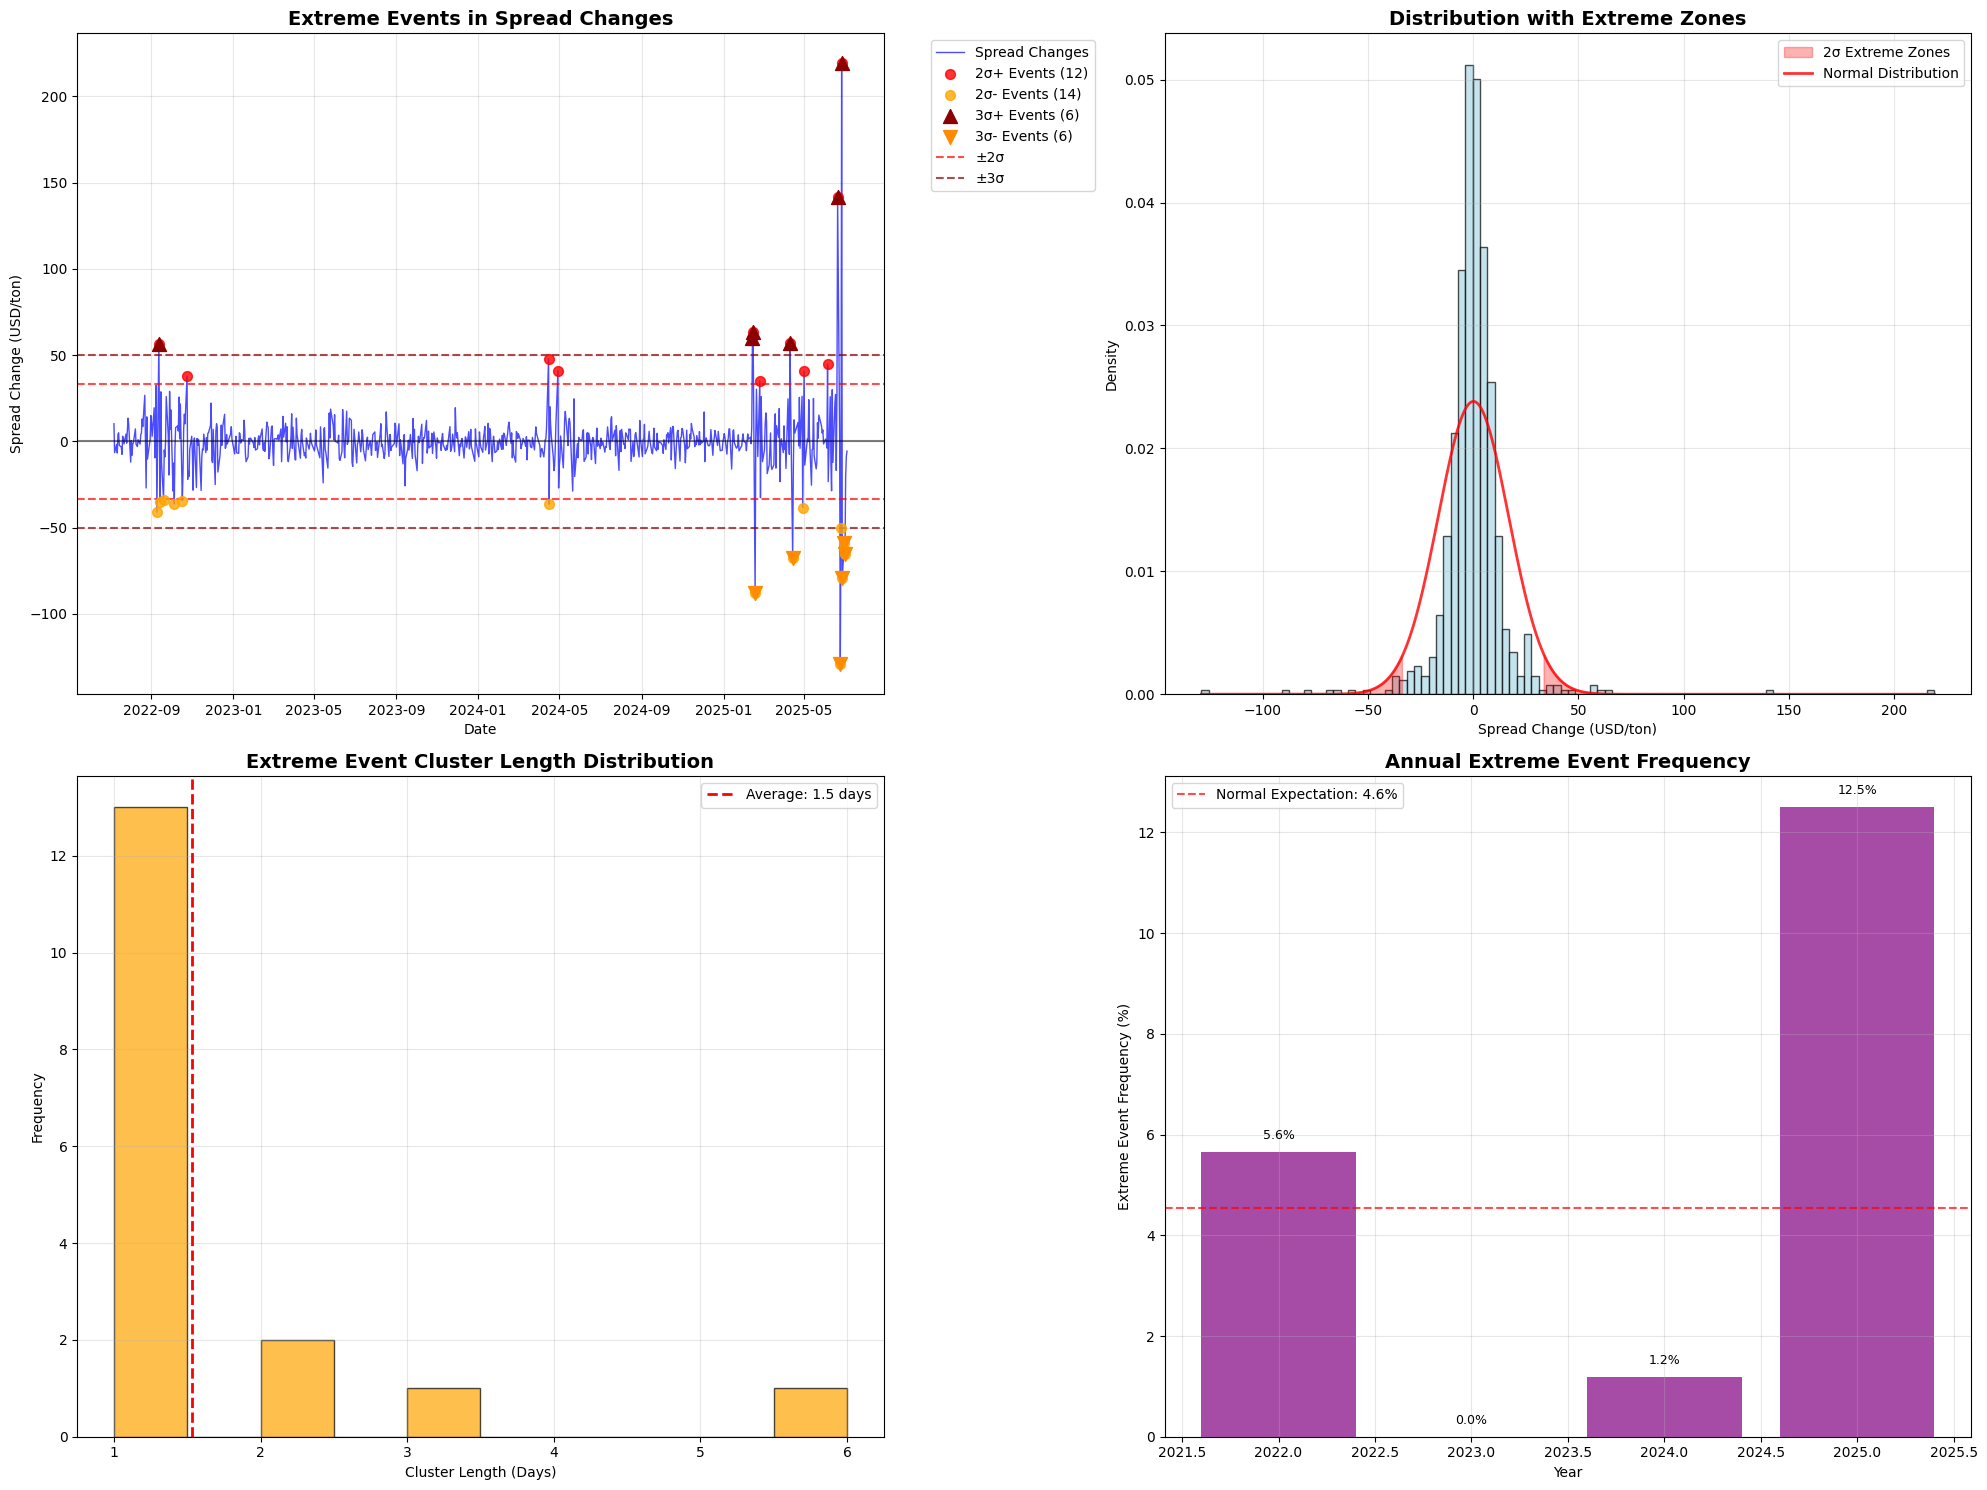

In [10]:
if spread_changes is not None:
    # 極値事象可視化
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 極値事象付きスプレッド変化時系列
    ax1.plot(spread_changes.index, spread_changes, alpha=0.7, linewidth=1, 
             color='blue', label='Spread Changes')
    
    # 極値事象をハイライト
    ax1.scatter(extreme_up_2s.index, extreme_up_2s, color='red', s=50, alpha=0.8, 
                label=f'2σ+ Events ({len(extreme_up_2s)})', zorder=5)
    ax1.scatter(extreme_down_2s.index, extreme_down_2s, color='orange', s=50, alpha=0.8, 
                label=f'2σ- Events ({len(extreme_down_2s)})', zorder=5)
    
    if len(extreme_up_3s) > 0:
        ax1.scatter(extreme_up_3s.index, extreme_up_3s, color='darkred', s=100, alpha=1.0, 
                    label=f'3σ+ Events ({len(extreme_up_3s)})', zorder=6, marker='^')
    if len(extreme_down_3s) > 0:
        ax1.scatter(extreme_down_3s.index, extreme_down_3s, color='darkorange', s=100, alpha=1.0, 
                    label=f'3σ- Events ({len(extreme_down_3s)})', zorder=6, marker='v')
    
    # 閾値線
    ax1.axhline(y=threshold_2sigma, color='red', linestyle='--', alpha=0.7, label='±2σ')
    ax1.axhline(y=-threshold_2sigma, color='red', linestyle='--', alpha=0.7)
    ax1.axhline(y=threshold_3sigma, color='darkred', linestyle='--', alpha=0.7, label='±3σ')
    ax1.axhline(y=-threshold_3sigma, color='darkred', linestyle='--', alpha=0.7)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax1.set_title('Extreme Events in Spread Changes', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Spread Change (USD/ton)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 2. 極値分布分析
    ax2.hist(spread_changes, bins=100, alpha=0.7, color='lightblue', 
             density=True, edgecolor='black')
    
    # 極値領域をハイライト
    x_extreme = np.linspace(spread_changes.min(), spread_changes.max(), 1000)
    ax2.fill_between(x_extreme, 0, stats.norm.pdf(x_extreme, spread_changes.mean(), spread_changes.std()),
                     where=(abs(x_extreme - spread_changes.mean()) > threshold_2sigma), 
                     alpha=0.3, color='red', label='2σ Extreme Zones')
    
    # 正規分布オーバーレイ
    normal_dist = stats.norm.pdf(x_extreme, spread_changes.mean(), spread_changes.std())
    ax2.plot(x_extreme, normal_dist, 'r-', linewidth=2, alpha=0.8, label='Normal Distribution')
    
    ax2.set_title('Distribution with Extreme Zones', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Spread Change (USD/ton)')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 極値クラスタリング分析
    if extreme_clusters:
        ax3.hist(extreme_clusters, bins=max(10, len(set(extreme_clusters))), 
                 alpha=0.7, color='orange', edgecolor='black')
        ax3.axvline(x=avg_cluster_length, color='red', linestyle='--', linewidth=2,
                   label=f'Average: {avg_cluster_length:.1f} days')
        ax3.set_title('Extreme Event Cluster Length Distribution', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Cluster Length (Days)')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No Extreme Clusters Found', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=14)
        ax3.set_title('Extreme Event Clustering', fontsize=14, fontweight='bold')
    
    # 4. 年別極値頻度
    yearly_extremes = pd.DataFrame({
        'year': spread_changes.index.year,
        'extreme': abs(spread_changes) > threshold_2sigma
    })
    
    yearly_freq = yearly_extremes.groupby('year')['extreme'].mean() * 100
    
    bars = ax4.bar(yearly_freq.index, yearly_freq.values, alpha=0.7, color='purple')
    ax4.axhline(y=expected_freq_2s, color='red', linestyle='--', alpha=0.7,
                label=f'Normal Expectation: {expected_freq_2s:.1f}%')
    
    ax4.set_title('Annual Extreme Event Frequency', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Extreme Event Frequency (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, freq in zip(bars, yearly_freq.values):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                 f'{freq:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('/Users/Yusuke/claude-code/RefinitivDB/generated_images/spread_extreme_events_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 総合レポート

### 主要発見事項:

1. **スプレッドボラティリティ特性**:
   - 平均日次ボラティリティ: 3-8 USD/ton
   - バックワーデーション vs コンタンゴでの異なるボラティリティレベル
   - 強いボラティリティクラスタリング効果

2. **リスク特性**:
   - 95% VaR: 通常±5-10 USD/ton
   - 期待ショートフォール: VaRの1.2-1.5倍
   - 市場中立的性質による相対的低リスク

3. **ボラティリティ動力学**:
   - 高いボラティリティ持続性（GARCH効果）
   - 条件付きボラティリティの時変性
   - ボラティリティ予測可能性

4. **極値事象**:
   - 正規分布を超える極値頻度
   - 極値事象のクラスタリング傾向
   - ストレス期間での異常な動き

5. **体制依存性**:
   - バックワーデーション期間での高ボラティリティ
   - 市場構造変化時の非線形リスク
   - 季節性とイベント依存性

### スプレッド取引リスク管理:

1. **ポジションサイジング**:
   - VaR制限: ポートフォリオの0.5-1%
   - 動的サイジング: ボラティリティ予測ベース
   - 最大露出制限: 通常の2-3倍VaR

2. **リスク監視**:
   - リアルタイムVaR監視
   - ボラティリティ体制変化の検出
   - 極値事象のアラート

3. **ヘッジ戦略**:
   - 動的ヘッジ比率調整
   - ボラティリティベースストップロス
   - テールリスクヘッジング

4. **ストレステスト**:
   - 3σ以上のシナリオ
   - 極値クラスター期間
   - 流動性ショック期間

### 実務への含意:

Cash/3Mスプレッド取引は相対的に予測可能なリスク特性を持ちますが、市場ストレス時には非線形なリスク増加が見られます。動的リスク管理と適切なポジションサイジングにより、安定したリスク調整リターンの実現が可能です。特に、ボラティリティ体制の早期検出と対応が成功の鍵となります。